## Setup

In [1]:
import os
import sys

root = os.path.dirname(os.getcwd())
sys.path.append(root)
sys.path.append(os.path.join(root, "src"))

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from src.data.synthetic import DataSynthetic, M0_G0_SETUPS
from src.models.dml_sklearn import DoubleMachineLearningSklearn
from src.utils.parser import Parser
from tqdm import tqdm

In [6]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

In [4]:
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
palette = sns.color_palette("Set1")

In [5]:
opts = Parser.double_ml()
opts.n_exp = 10000
opts.real_theta = 1.0
opts.majority_s = 0.8
opts.dml_net = 'NonLinearNet'

## Goal
estimate the treatment effect given data obeys the Partially Linear Regression model (PLR).

## Double Machine Learning estimation

Double Machine Learning:
1. Input: data $(X_i \in \mathbb{R}^d, D_i \in \mathbb{R}, Y_i \in \mathbb{R})_{i=1}^n$.
2. Split $\{1, . . . , n\}$ into two disjoint subsets: $\mathcal{I}_1, \mathcal{I}_2$.
3. Train $\hat{m}(X)$ and $\hat{\ell}(X)$ on $\mathcal{I}_1$ to estimate $m(X)$ and $\ell(X)$ in the PLR model.
4. Estimate $\theta$ using the data in $\mathcal{I}_2$ as follow: $\hat{\theta} = \big(\sum_{i \in \mathcal{I}_2} \hat{V}_i \big)^{-1} \sum_{i \in \mathcal{I}_2} \hat{V}_i \hat{U}_i$, where: $\hat{V}_i = D_i - \hat{m}(X_i), \hat{U}_i = Y_i - \hat{\ell}(X_i)$.

In [7]:
def dml_theta_estimator(y: np.ndarray, d: np.ndarray, m_hat: np.ndarray, l_hat: np.ndarray) -> float:
    v_hat = d - m_hat
    u_hat = y - l_hat
    theta_hat = np.mean(v_hat * u_hat) / np.mean(v_hat * v_hat)
    return theta_hat.item()

## Bias in Double Machine Learning

In our paper, [Coordinated Double Machine Learning](https://arxiv.org/abs/2206.00885) [1] we analyze the bias in the treatment effect estimation of DML.

**Theorem 2.3.** Under Assumptions 2.1–2.2 in [1], for $n$ large enough, with probability at least $1 − \mathcal{O}(n−1)$ the DML treatment effect estimate satisfies: 
<center>
$\hat{\theta} - \theta = \mathcal{B}_{DML} + \mathcal{O}(\sqrt{(\log n) / n})$
</center>
where: 
<center>
$\mathcal{B}_{DML} = \frac{\mathbb{E}\left[{\Delta \hat{m}(X) \Delta \hat{\ell}(X) \mid \mathcal{I}_1}\right] - \theta \cdot \mathbb{E} \left[{\left(\Delta \hat{m}(X) \right)^2 \mid \mathcal{I}_1}\right]}{\mathrm{Var}\left[{V}\right] + \mathbb{E} \left[{\left(\Delta \hat{m}(X) \right)^2 \mid \mathcal{I}_1}\right]}$
</center>

To demonstrate the validity of the above, we run DML and report the empirical bias, which is the a-posteriori measured difference $\hat{\theta}_{DML} - \theta$, and compare it to the theoretical bias above; $\mathcal{B}_{DML}$.

The below method runs DML once:

In [7]:
def run_dml(opts, data, double_ml, double_ml_params, seed: int = None, l_hat_noise: float = None) -> pd.DataFrame:
    
    ################ generate data ################
    train, test = data.generate(real_theta=opts.real_theta, train_size=0.5, seed=exp)
    
    ################### fit DML ###################
    m_hat, l_hat = double_ml.fit(train, test, **double_ml_params).predict(test["x"])
    if l_hat_noise is not None:
        l_hat += l_hat_noise * np.random.randn(len(l_hat))

    ################ measure bias #################
    theta_hat = dml_theta_estimator(test["y"], test["d"], m_hat, l_hat)
    empirical_bias = theta_hat - opts.real_theta

    ################# actual bias #################
    m_x, g_x = M0_G0_SETUPS[opts.m0_g0_setup](test["x"], test["majority"], test["minority"])
    l_x = m_x * opts.real_theta + g_x

    v = test["d"] - m_x
    var_v = np.mean(v ** 2)
    
    delta_m, delta_l = m_x - m_hat, l_x - l_hat
    corr = np.mean(delta_m * delta_l)
    delta_m_square = np.mean(delta_m ** 2)

    theoretical_bias = (corr - opts.real_theta * delta_m_square) / (var_v + delta_m_square)
    ###############################################

    return pd.DataFrame({
        "theta hat": theta_hat,
        "Empirical Bias": empirical_bias,
        "Theoretical Bias": theoretical_bias,
        "Squared Diff": (empirical_bias - theoretical_bias) ** 2,
    }, index=[exp])

The code below runs multiple experiments and collects the empirical and theoretical bias of each:

In [8]:
data = DataSynthetic.init_from_opts(opts, as_tensors=False)

double_ml = DoubleMachineLearningSklearn.init_from_opts(opts=opts)
double_ml_params = double_ml.fit_params(opts=opts)

df = pd.DataFrame()
for exp in tqdm(range(opts.n_exp)):
    double_ml.restart()
    exp_df = run_dml(opts, data, double_ml, double_ml_params, seed=exp)
    df = pd.concat([df, exp_df])

100%|██████████| 10000/10000 [00:31<00:00, 320.75it/s]


The code below plots the results of the above experiments:

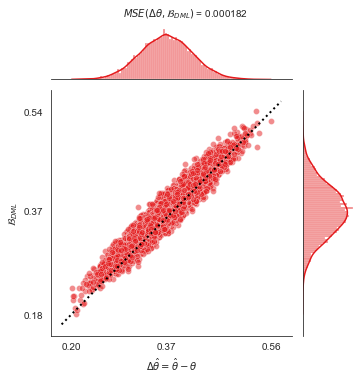

In [9]:
with sns.axes_style("white"):
    x = sns.jointplot(
        data=df,
        x="Empirical Bias",
        y="Theoretical Bias",
        height=5,
        ratio=4,
        marginal_ticks=False,
        color=palette[0],
        alpha=0.5,
        marginal_kws=dict(bins=int(np.sqrt(opts.n_exp)), stat="probability", kde=True, alpha=0.5,),
    )

    x.ax_joint.plot(x.ax_joint.get_xlim(), x.ax_joint.get_ylim(), linewidth=2.0, linestyle=":", color="black")

    points = [np.min(df["Empirical Bias"]), np.mean(df["Empirical Bias"]), np.max(df["Empirical Bias"])]
    x.ax_joint.set_xticks(points)
    x.ax_joint.set_xticklabels(["{:.2f}".format(x) for x in points])

    points = [np.min(df["Theoretical Bias"]), np.mean(df["Theoretical Bias"]), np.max(df["Theoretical Bias"])]
    x.ax_joint.set_yticks(points)
    x.ax_joint.set_yticklabels(["{:.2f}".format(x) for x in points])

    x.ax_joint.set_xlabel(r"$\Delta \hat{\theta} = \hat{\theta} - \theta$", fontsize=10)
    x.ax_joint.set_ylabel(r"$\mathcal{B}_{DML}$", fontsize=10)
    x.fig.suptitle(r"$MSE(\Delta \theta, \mathcal{B}_{DML})$" + " = {:.6f}".format(np.mean(df["Squared Diff"])), fontsize=10, y=1.025)

plt.show();

In the above figure we see how the empirical bias (on the x-axis) and theoretical bias (on the y-axis) coincide, approving Theorem 2.3.

## Bias under inaccurate estimation of $\ell(X)$

To show how theorem 2.3 is robust to noisy estimation of $\ell(X)$ we add noise that is samples from a Gaussian distribution with increasing variance to the prediction of DML $\hat{\ell(X)}$, and repeat the above experiments. Below is a utility code for plotting the results per noise level:

In [13]:
def plot_noisy_graph(df, ax, noise: float):   
    sns.scatterplot(data=df, x="Empirical Bias", y="Theoretical Bias", color=palette[0], alpha=0.5, ax=ax)
    ax.plot(ax.get_xlim(), ax.get_ylim(), linewidth=2.0, linestyle=":", color="black")

    ax.set_xlabel(r"$\Delta \hat{\theta} = \hat{\theta} - \theta$", fontsize=10)
    ax.set_ylabel(r"$\mathcal{B}_{DML}$", fontsize=10)
    ax.set_title(
        r"$\sigma_{\ell}=$" + str(noise) + "\n" + r"$MSE(\Delta \theta, \mathcal{B}_{DML})$" + 
        " = {:.6f}".format(np.mean(df["Squared Diff"])), fontsize=10, y=1.025)

    points = [np.min(df["Empirical Bias"]), np.mean(df["Empirical Bias"]), np.max(df["Empirical Bias"])]
    ax.set_xticks(points)
    ax.set_xticklabels(["{:.2f}".format(x) for x in points])

    points = [np.min(df["Theoretical Bias"]), np.mean(df["Theoretical Bias"]), np.max(df["Theoretical Bias"])]
    ax.set_yticks(points)
    ax.set_yticklabels(["{:.2f}".format(x) for x in points])

Now we can repeat the experiments:

running with noise = 25.0: 100%|██████████| 10000/10000 [00:32<00:00, 309.43it/s]


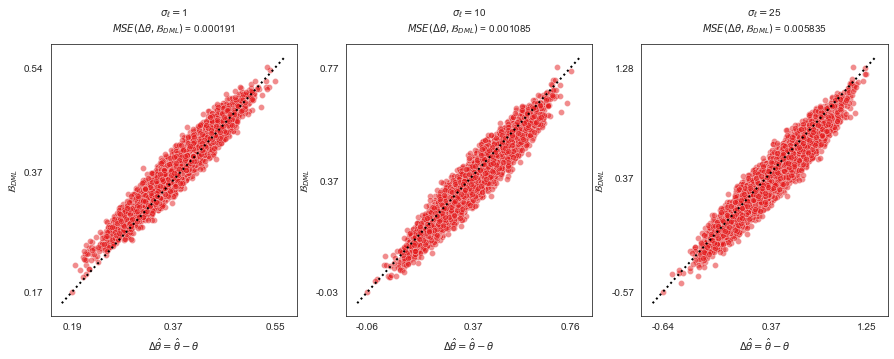

In [14]:
data = DataSynthetic.init_from_opts(opts, as_tensors=False)

double_ml = DoubleMachineLearningSklearn.init_from_opts(opts=opts)
double_ml_params = double_ml.fit_params(opts=opts)

noises = (1, 10, 25)

with sns.axes_style("white"):
    _, axs = plt.subplots(1, len(noises), figsize=(len(noises) * 5, 5))
    
for i, noise in enumerate(noises):
    df = pd.DataFrame()
    for exp in tqdm(range(opts.n_exp), desc='running with noise = {:.1f}'.format(noise)):
        double_ml.restart()
        exp_df = run_dml(opts, data, double_ml, double_ml_params, seed=exp, l_hat_noise=noise)
        df = pd.concat([df, exp_df])
    plot_noisy_graph(df, axs[i], noise)
plt.show();